In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_PINN_int import *
from NN_library.train_dual_PINN_int import *
from matplotlib.tri import Triangulation
from utility import *
from PDE_losses import PDE_loss, PDE_loss_dual
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def A_interp(x, eps): 
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x, eps):  
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = 1/a.view(-1,1,1) * I
    return A

def A(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

In [9]:
net_primal_65_10 = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_primal_{10}_{65}'}

net_primal_65_10 = load_network(net_primal_65_10, args['name']+'_39999', args)
net_primal_65_10 = net_primal_65_10.to(dev)

In [10]:
net_primal_15601_30 = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_primal_{30}_{15601}'}

net_primal_15601_30 = load_network(net_primal_15601_30, args['name']+'_39999', args)
net_primal_15601_30 = net_primal_15601_30.to(dev)

In [11]:
net_primal_15601_40 = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_primal_{40}_{15601}'}

net_primal_15601_40 = load_network(net_primal_15601_40, args['name']+'_39999', args)
net_primal_15601_40 = net_primal_15601_40.to(dev)

In [12]:
U1_1 = net_primal_65_10(grid_data).detach().cpu().reshape(N, N)
U1_2 = net_primal_15601_30(grid_data).detach().cpu().reshape(N, N)
U1_3 = net_primal_15601_40(grid_data).detach().cpu().reshape(N, N)

error_1_p, _, _ = PDE_loss(grid_data, net_primal_65_10, lambda x: A_interp(x, 10), H1)
error_1_p = error_1_p.detach().cpu().reshape(N, N)

error_2_p, _, _ = PDE_loss(grid_data, net_primal_15601_30, lambda x: A_interp(x, 30), H1)
error_2_p = error_2_p.detach().cpu().reshape(N, N)

error_3_p, _, _ = PDE_loss(grid_data, net_primal_15601_40, lambda x: A_interp(x, 40), H1)
error_3_p = error_3_p.detach().cpu().reshape(N, N)

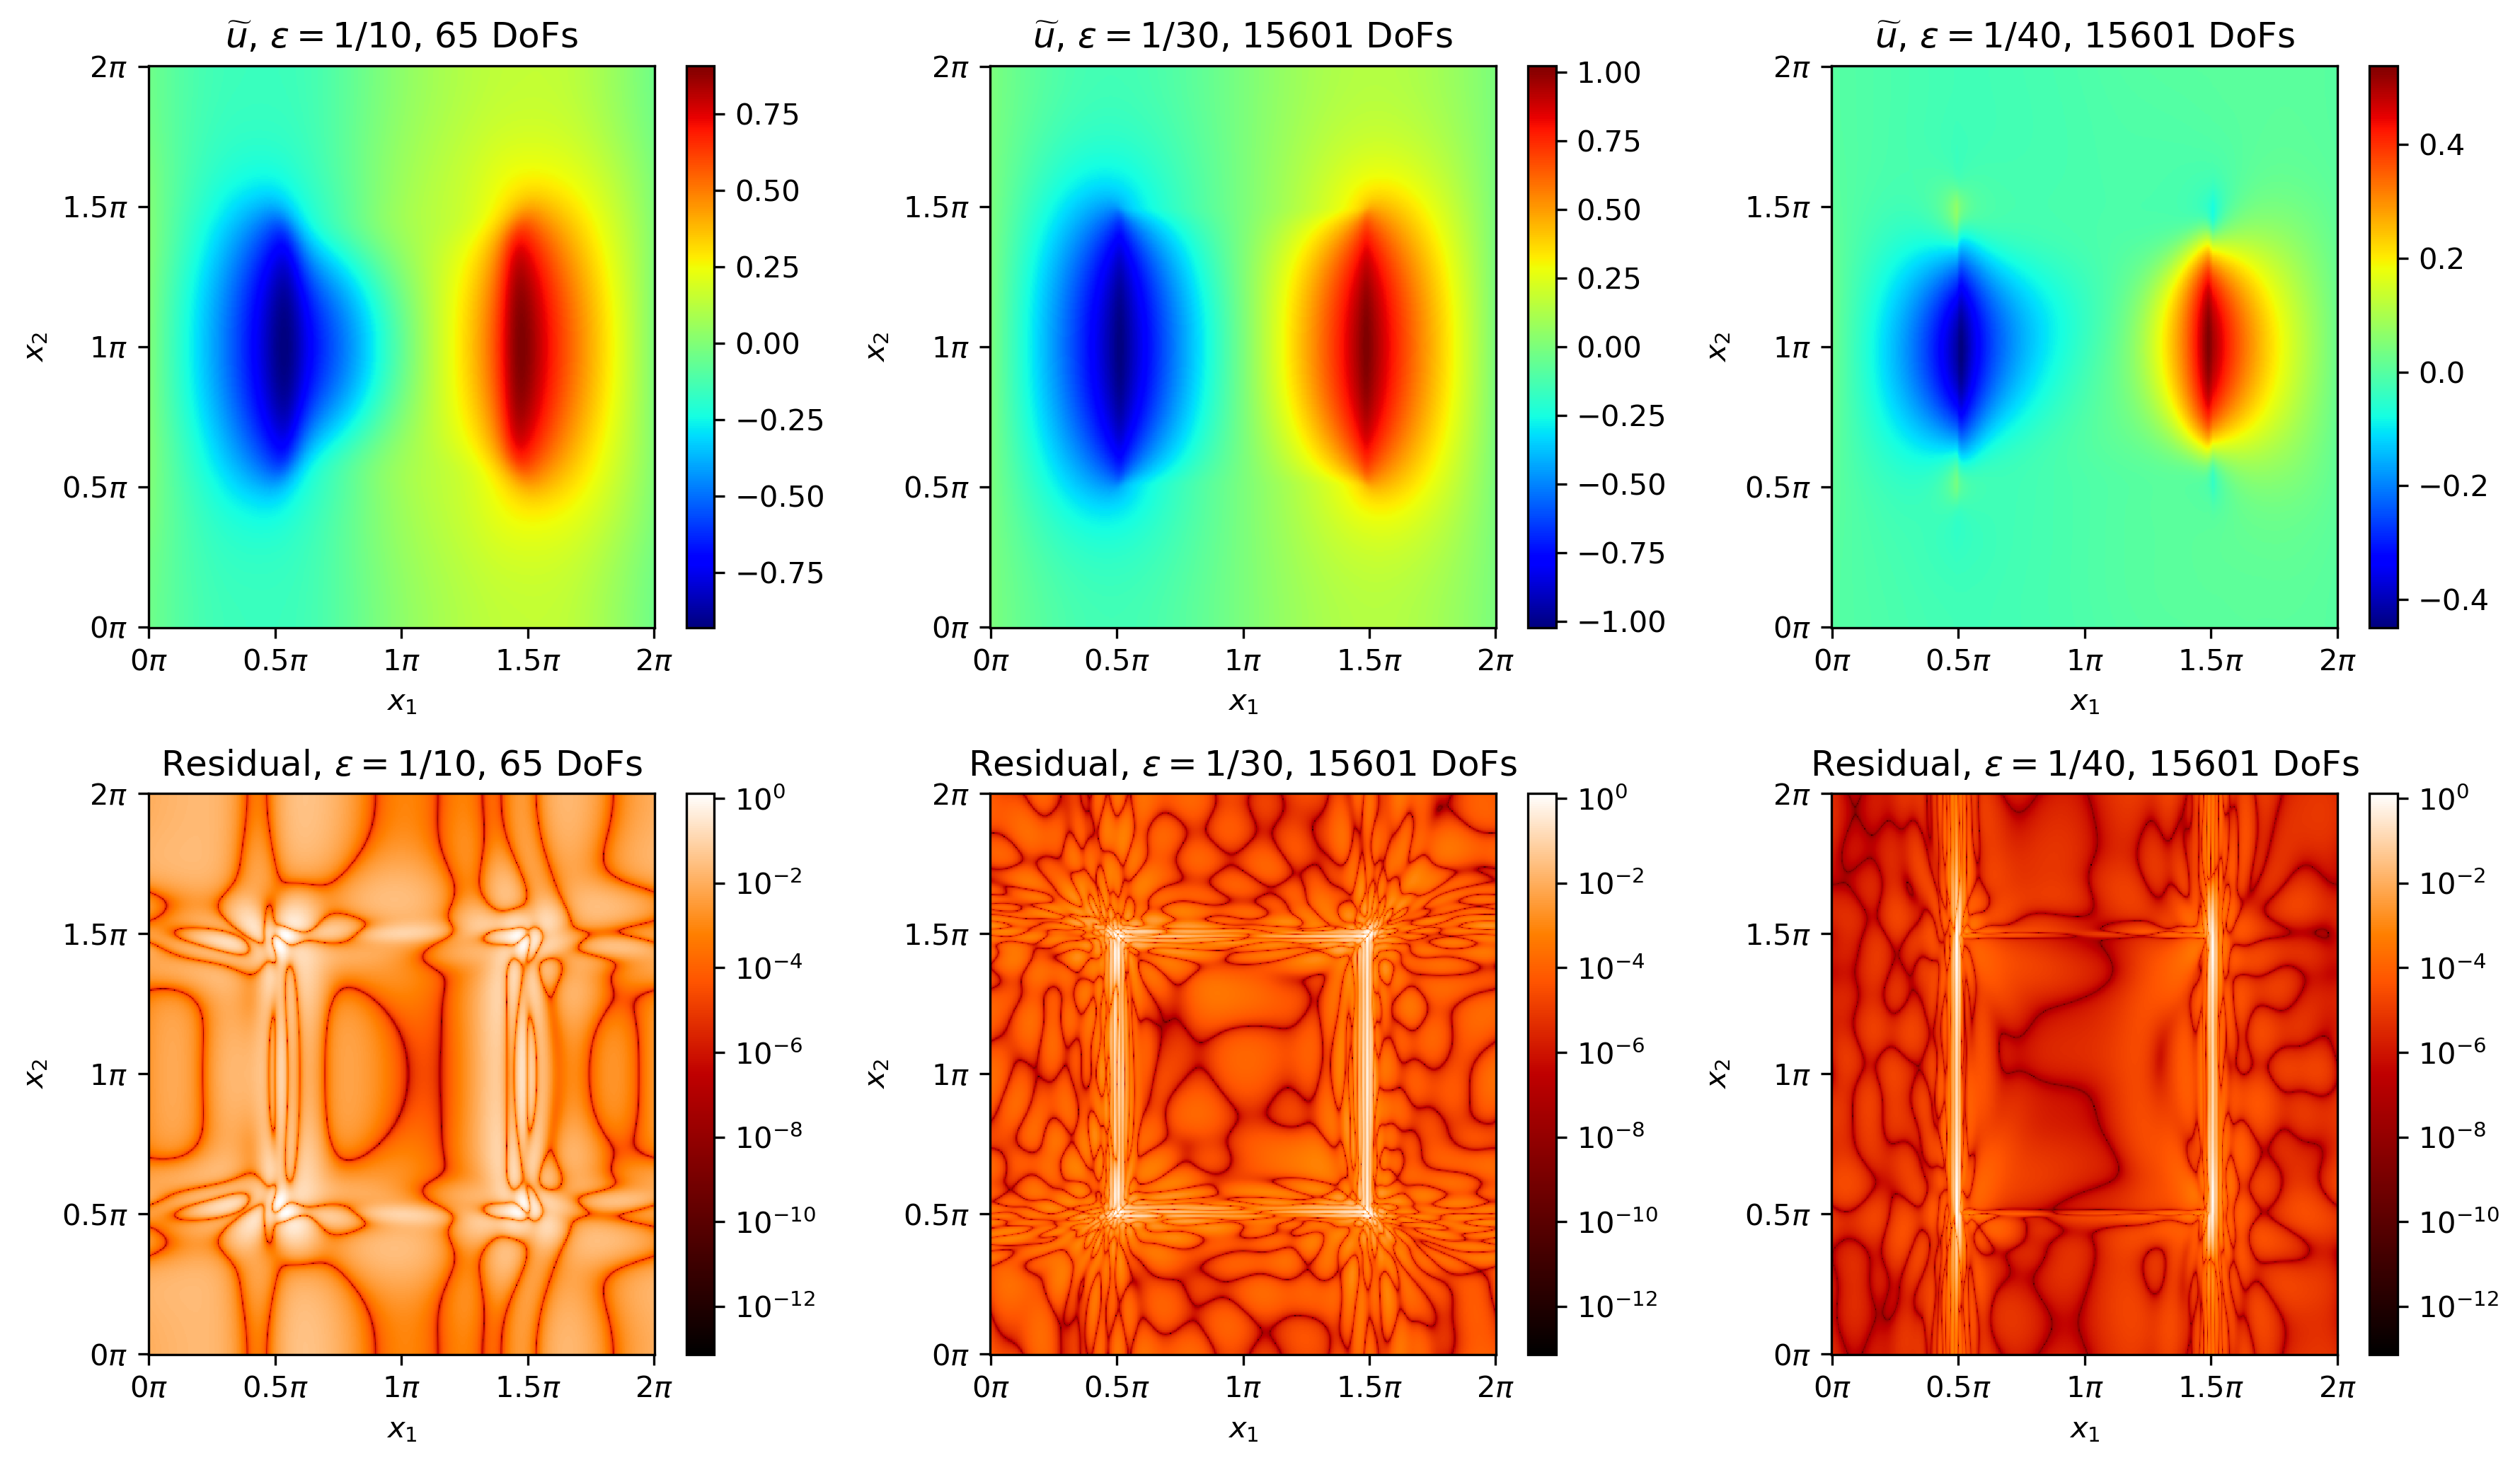

In [19]:
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,7), dpi=300)

for i in range(6):
    axs.flat[i].set_xlabel('$x_1$')
    axs.flat[i].set_ylabel('$x_2$')

pos1 = axs[0,0].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, U1_1, cmap='jet')
fig.colorbar(pos1, ax=axs[0,0])
pos2 = axs[0,1].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, U1_2, cmap='jet')
fig.colorbar(pos2, ax=axs[0,1])
pos3 = axs[0,2].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, U1_3, cmap='jet')
fig.colorbar(pos3, ax=axs[0,2])

axs[0,0].set_title('$\widetilde{u}$, $\epsilon=1/10$, 65 DoFs')
axs[0,1].set_title('$\widetilde{u}$, $\epsilon=1/30$, 15601 DoFs')
axs[0,2].set_title('$\widetilde{u}$, $\epsilon=1/40$, 15601 DoFs')

axs[1,0].set_title('Residual, $\epsilon=1/10$, 65 DoFs')
axs[1,1].set_title('Residual, $\epsilon=1/30$, 15601 DoFs')
axs[1,2].set_title('Residual, $\epsilon=1/40$, 15601 DoFs')

pos1 = axs[1,0].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_1_p**2, cmap='gist_heat', norm=LogNorm(vmin=(error_1_p**2).min(), vmax=(error_1_p**2).max()))
fig.colorbar(pos1, ax=axs[1,0])
pos2 = axs[1,1].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_2_p**2, cmap='gist_heat', norm=LogNorm(vmin=(error_2_p**2).min(), vmax=(error_2_p**2).max()))
fig.colorbar(pos1, ax=axs[1,1])
pos2 = axs[1,2].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_3_p**2, cmap='gist_heat', norm=LogNorm(vmin=(error_3_p**2).min(), vmax=(error_3_p**2).max()))
fig.colorbar(pos1, ax=axs[1,2])

for i in range(3):
    axs[0,i].xaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[0,i].xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[0,i].yaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[0,i].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[1,i].xaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[1,i].xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[1,i].yaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[1,i].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))

plt.tight_layout()

In [3]:
net_dual_65_10 = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_dual_{10}_{65}'}

net_dual_65_10 = load_network(net_dual_65_10, args['name']+'_39999', args)
net_dual_65_10 = net_dual_65_10.to(dev)

In [4]:
net_dual_15601_30 = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_dual_{30}_{15601}'}

net_dual_15601_30 = load_network(net_dual_15601_30, args['name']+'_39999', args)
net_dual_15601_30 = net_dual_15601_30.to(dev)

In [5]:
net_dual_15601_40 = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_dual_{40}_{15601}'}

net_dual_15601_40 = load_network(net_dual_15601_40, args['name']+'_39999', args)
net_dual_15601_40 = net_dual_15601_40.to(dev)

In [6]:
W1_1 = net_dual_65_10(grid_data).detach().cpu().reshape(N, N)
W1_2 = net_dual_15601_30(grid_data).detach().cpu().reshape(N, N)
W1_3 = net_dual_15601_40(grid_data).detach().cpu().reshape(N, N)

error_1_d, _, _ = PDE_loss_dual(grid_data, net_dual_65_10, lambda x: A_interp_inv(x, 10), H1)
error_1_d = error_1_d.detach().cpu().reshape(N, N)

error_2_d, _, _ = PDE_loss_dual(grid_data, net_dual_15601_30, lambda x: A_interp_inv(x, 30), H1)
error_2_d = error_2_d.detach().cpu().reshape(N, N)

error_3_d, _, _ = PDE_loss_dual(grid_data, net_dual_15601_40, lambda x: A_interp_inv(x, 40), H1)
error_3_d = error_3_d.detach().cpu().reshape(N, N)

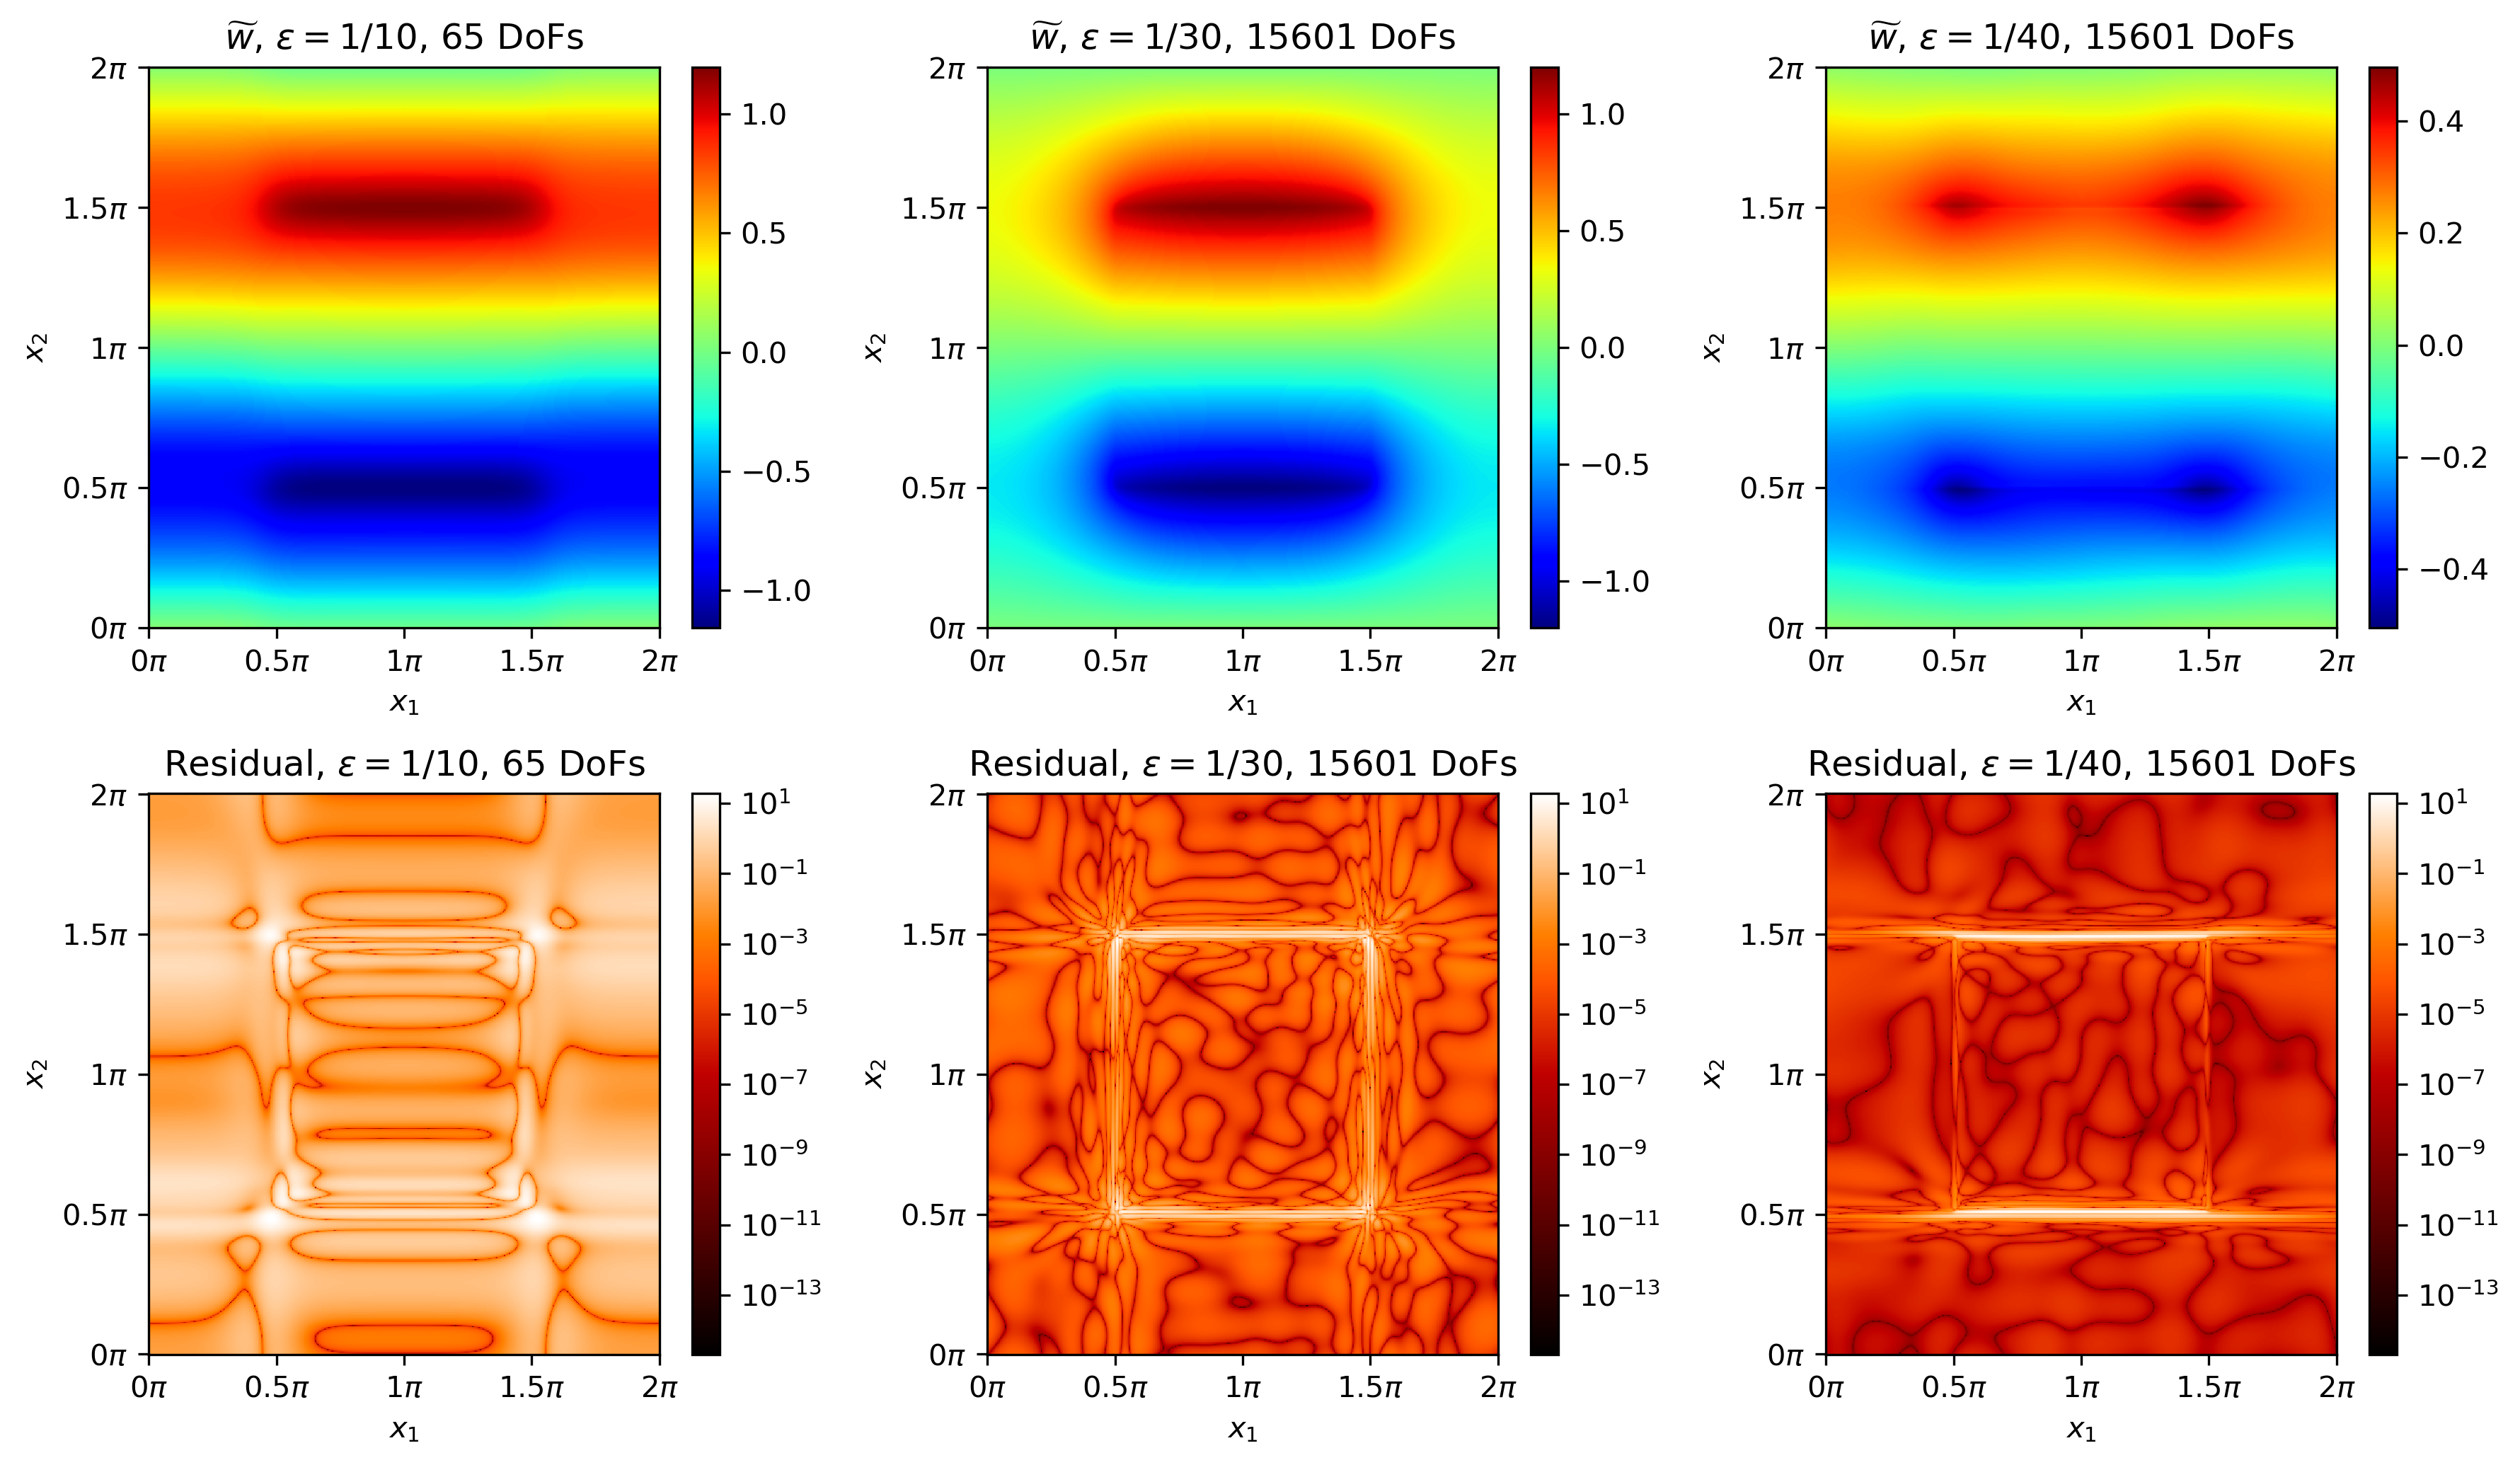

In [8]:
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,7), dpi=300)

for i in range(6):
    axs.flat[i].set_xlabel('$x_1$')
    axs.flat[i].set_ylabel('$x_2$')

pos1 = axs[0,0].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, W1_1, cmap='jet')
fig.colorbar(pos1, ax=axs[0,0])
pos2 = axs[0,1].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, W1_2, cmap='jet')
fig.colorbar(pos2, ax=axs[0,1])
pos3 = axs[0,2].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, W1_3, cmap='jet')
fig.colorbar(pos3, ax=axs[0,2])

axs[0,0].set_title('$\widetilde{w}$, $\epsilon=1/10$, 65 DoFs')
axs[0,1].set_title('$\widetilde{w}$, $\epsilon=1/30$, 15601 DoFs')
axs[0,2].set_title('$\widetilde{w}$, $\epsilon=1/40$, 15601 DoFs')

axs[1,0].set_title('Residual, $\epsilon=1/10$, 65 DoFs')
axs[1,1].set_title('Residual, $\epsilon=1/30$, 15601 DoFs')
axs[1,2].set_title('Residual, $\epsilon=1/40$, 15601 DoFs')

pos1 = axs[1,0].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_1_d**2, cmap='gist_heat', norm=LogNorm(vmin=(error_1_d**2).min(), vmax=(error_1_d**2).max()))
fig.colorbar(pos1, ax=axs[1,0])
pos2 = axs[1,1].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_2_d**2, cmap='gist_heat', norm=LogNorm(vmin=(error_2_d**2).min(), vmax=(error_2_d**2).max()))
fig.colorbar(pos1, ax=axs[1,1])
pos2 = axs[1,2].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_3_d**2, cmap='gist_heat', norm=LogNorm(vmin=(error_3_d**2).min(), vmax=(error_3_d**2).max()))
fig.colorbar(pos1, ax=axs[1,2])

for i in range(3):
    axs[0,i].xaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[0,i].xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[0,i].yaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[0,i].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[1,i].xaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[1,i].xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[1,i].yaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[1,i].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))

plt.tight_layout()

In [ ]:
net_primal_65_70 = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VSPINN_primal_{65}_{70}'}

net_primal_65_70 = load_network(net_primal_65_70, args['name']+'_39999', args)
net_primal_65_70 = net_primal_65_70.to(dev)

net_primal_15601_70 = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VSPINN_primal_{15601}_{70}'}

net_primal_15601_70 = load_network(net_primal_15601_70, args['name']+'_39999', args)
net_primal_15601_70 = net_primal_15601_70.to(dev)

net_primal_15601_126 = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VSPINN_primal_{15601}_{126}'}

net_primal_15601_126 = load_network(net_primal_15601_126, args['name']+'_39999', args)
net_primal_15601_126 = net_primal_15601_126.to(dev)

In [7]:
U1_1 = net_primal_65_70(grid_data).detach().cpu().reshape(N, N)
U1_2 = net_primal_15601_70(grid_data).detach().cpu().reshape(N, N)
U1_3 = net_primal_15601_126(grid_data).detach().cpu().reshape(N, N)

error_1_p, _, _ = PDE_loss(grid_data, net_primal_65_70, A, H1)
error_1_p = error_1_p.detach().cpu().reshape(N, N)

error_2_p, _, _ = PDE_loss(grid_data, net_primal_15601_70, A, H1)
error_2_p = error_2_p.detach().cpu().reshape(N, N)

error_3_p, _, _ = PDE_loss(grid_data, net_primal_15601_126, A, H1)
error_3_p = error_3_p.detach().cpu().reshape(N, N)

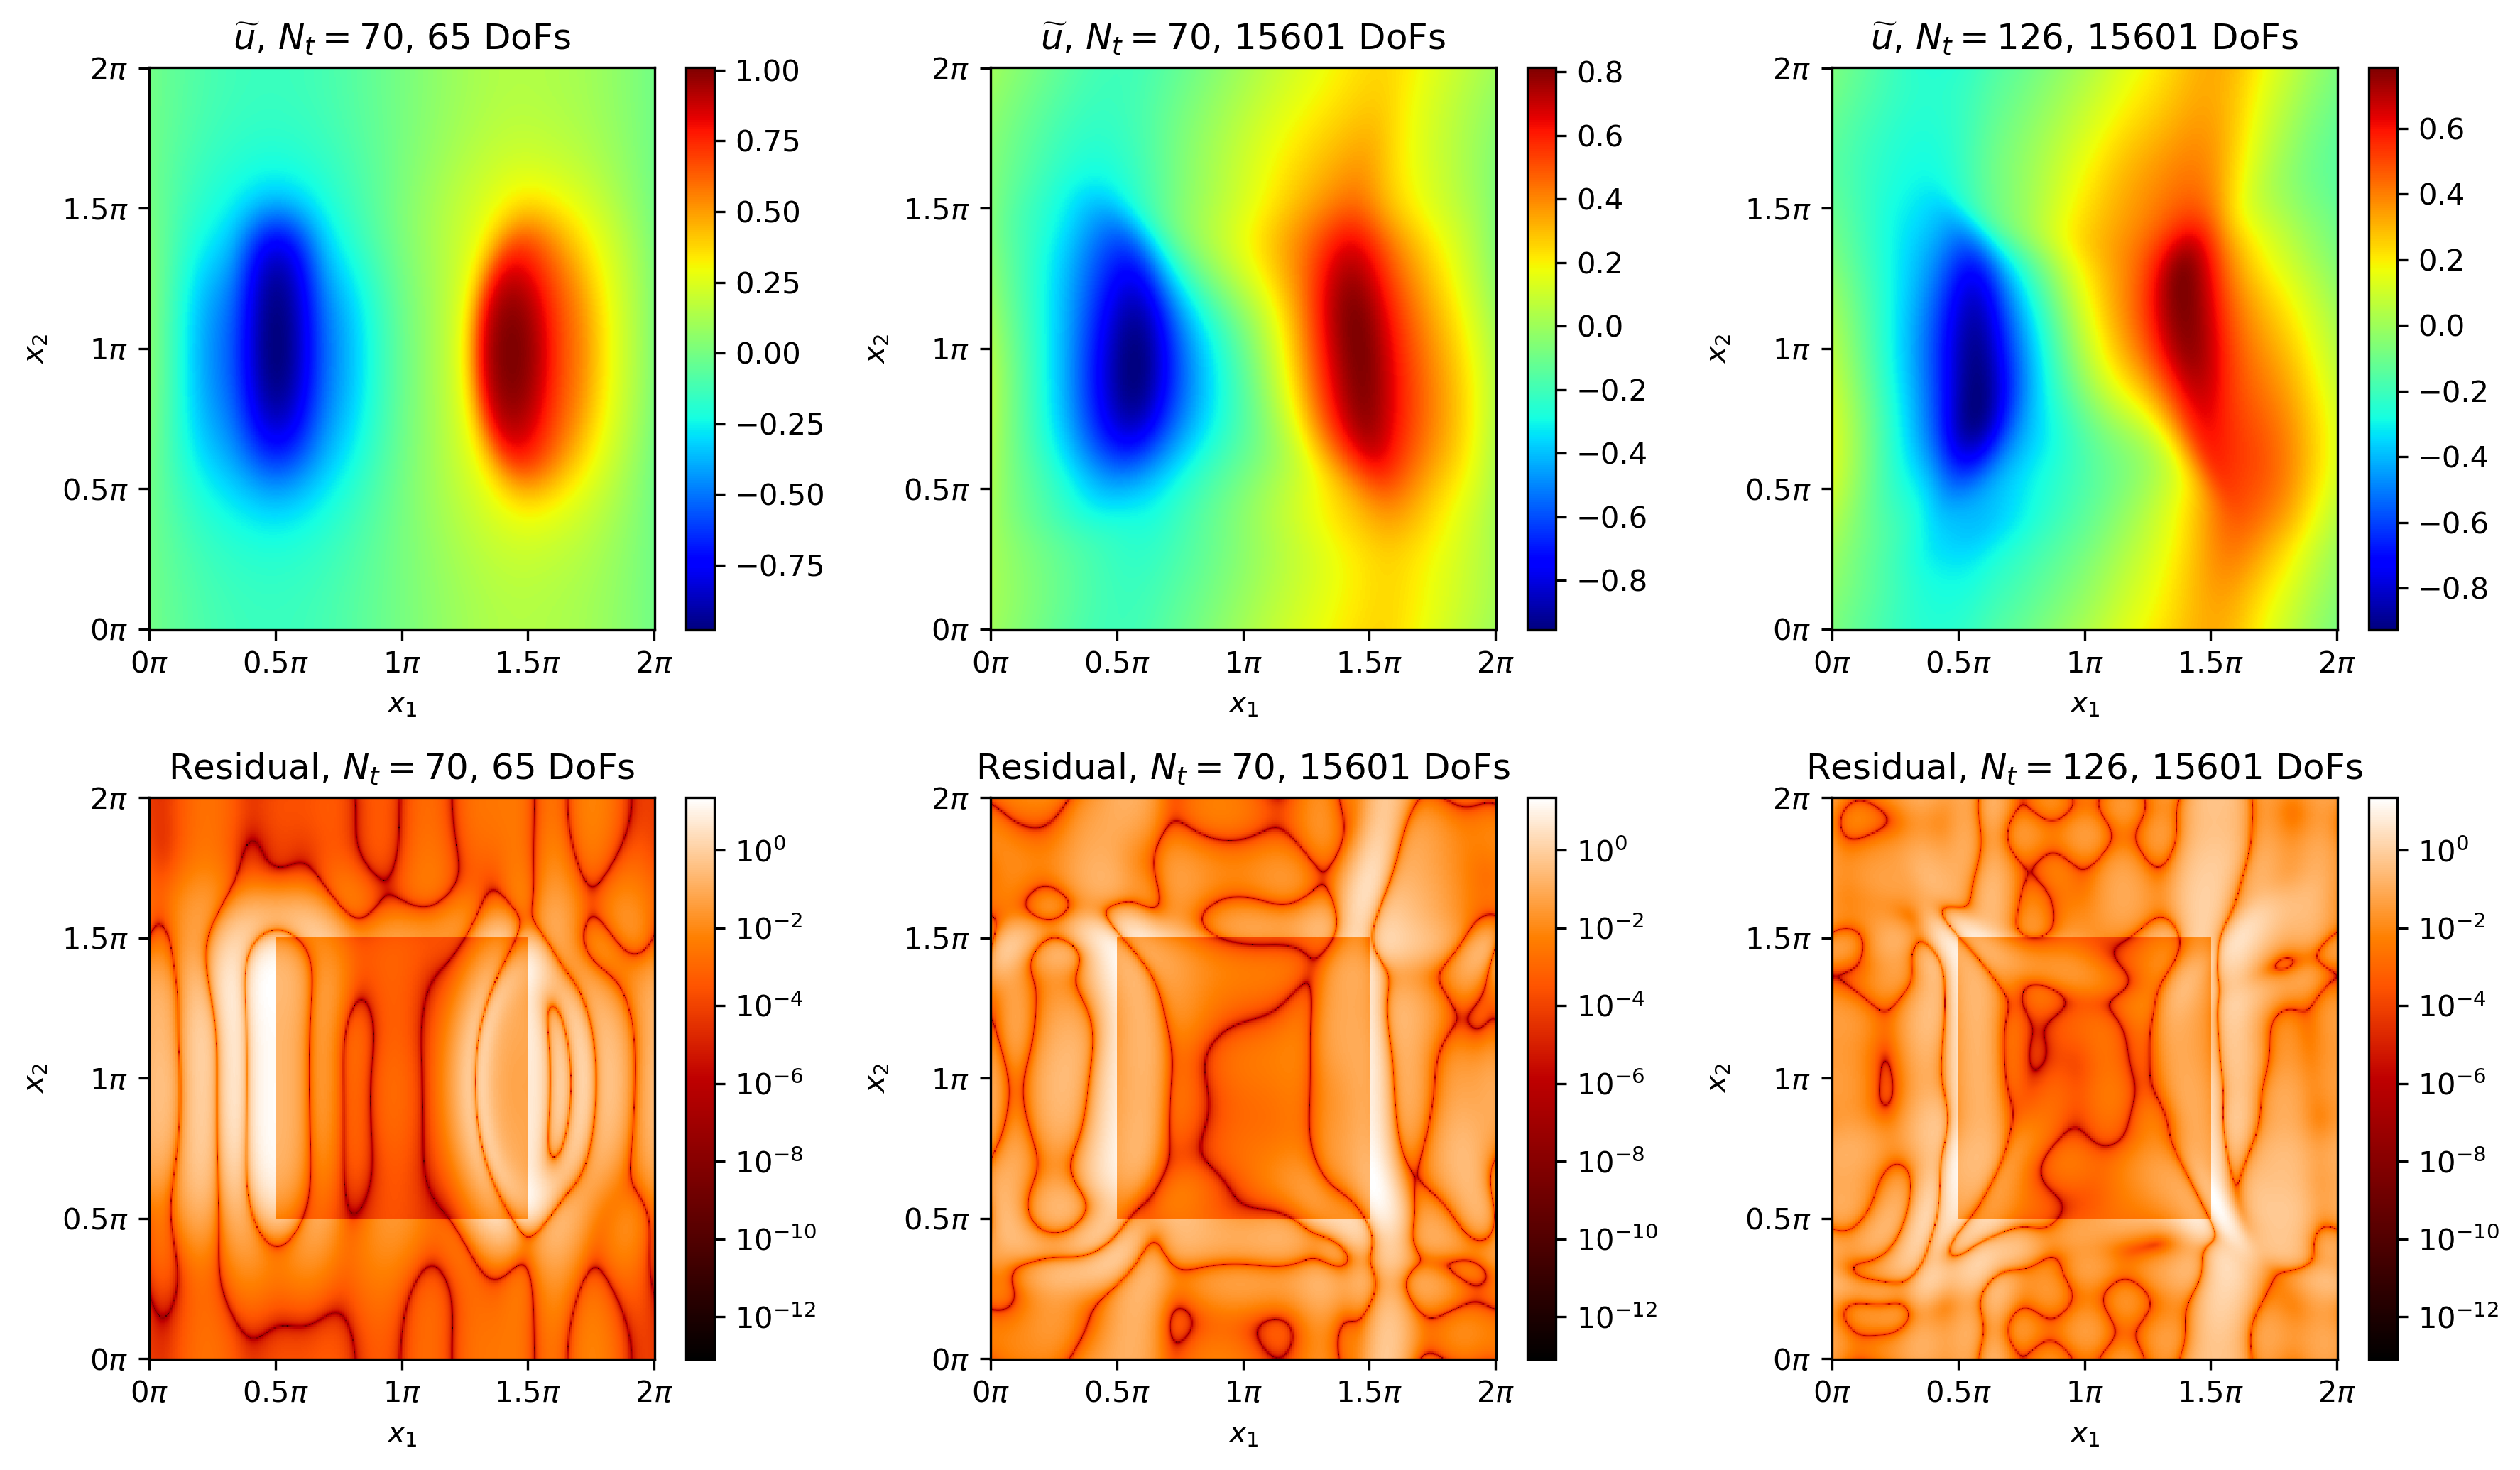

In [9]:
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,7), dpi=300)

for i in range(6):
    axs.flat[i].set_xlabel('$x_1$')
    axs.flat[i].set_ylabel('$x_2$')

pos1 = axs[0,0].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, U1_1, cmap='jet')
fig.colorbar(pos1, ax=axs[0,0])
pos2 = axs[0,1].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, U1_2, cmap='jet')
fig.colorbar(pos2, ax=axs[0,1])
pos3 = axs[0,2].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, U1_3, cmap='jet')
fig.colorbar(pos3, ax=axs[0,2])

axs[0,0].set_title('$\widetilde{u}$, $N_t=70$, 65 DoFs')
axs[0,1].set_title('$\widetilde{u}$, $N_t=70$, 15601 DoFs')
axs[0,2].set_title('$\widetilde{u}$, $N_t=126$, 15601 DoFs')

axs[1,0].set_title('Residual, $N_t=70$, 65 DoFs')
axs[1,1].set_title('Residual, $N_t=70$, 15601 DoFs')
axs[1,2].set_title('Residual, $N_t=126$, 15601 DoFs')

pos1 = axs[1,0].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_1_p**2, cmap='gist_heat', norm=LogNorm(vmin=(error_1_p**2).min(), vmax=(error_1_p**2).max()))
fig.colorbar(pos1, ax=axs[1,0])
pos2 = axs[1,1].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_2_p**2, cmap='gist_heat', norm=LogNorm(vmin=(error_2_p**2).min(), vmax=(error_2_p**2).max()))
fig.colorbar(pos1, ax=axs[1,1])
pos2 = axs[1,2].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_3_p**2, cmap='gist_heat', norm=LogNorm(vmin=(error_3_p**2).min(), vmax=(error_3_p**2).max()))
fig.colorbar(pos1, ax=axs[1,2])

for i in range(3):
    axs[0,i].xaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[0,i].xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[0,i].yaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[0,i].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[1,i].xaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[1,i].xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[1,i].yaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[1,i].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))

plt.tight_layout()

In [3]:
net_dual_65_70 = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VSPINN_dual_{65}_{70}'}

net_dual_65_70 = load_network(net_dual_65_70, args['name']+'_39999', args)
net_dual_65_70 = net_dual_65_70.to(dev)

In [4]:
net_dual_15601_70 = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VSPINN_dual_{15601}_{70}'}

net_dual_15601_70 = load_network(net_dual_15601_70, args['name']+'_39999', args)
net_dual_15601_70 = net_dual_15601_70.to(dev)

In [5]:
net_dual_15601_126 = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VSPINN_dual_{15601}_{126}'}

net_dual_15601_126 = load_network(net_dual_15601_126, args['name']+'_39999', args)
net_dual_15601_126 = net_dual_15601_126.to(dev)

In [9]:
W1_1 = net_dual_65_70(grid_data).detach().cpu().reshape(N, N)
W1_2 = net_dual_15601_70(grid_data).detach().cpu().reshape(N, N)
W1_3 = net_dual_15601_126(grid_data).detach().cpu().reshape(N, N)

error_1_d, _, _ = PDE_loss_dual(grid_data, net_dual_65_70, A_inv, H1)
error_1_d = error_1_d.detach().cpu().reshape(N, N)

error_2_d, _, _ = PDE_loss_dual(grid_data, net_dual_15601_70, A_inv, H1)
error_2_d = error_2_d.detach().cpu().reshape(N, N)

error_3_d, _, _ = PDE_loss_dual(grid_data, net_dual_15601_126, A_inv, H1)
error_3_d = error_3_d.detach().cpu().reshape(N, N)

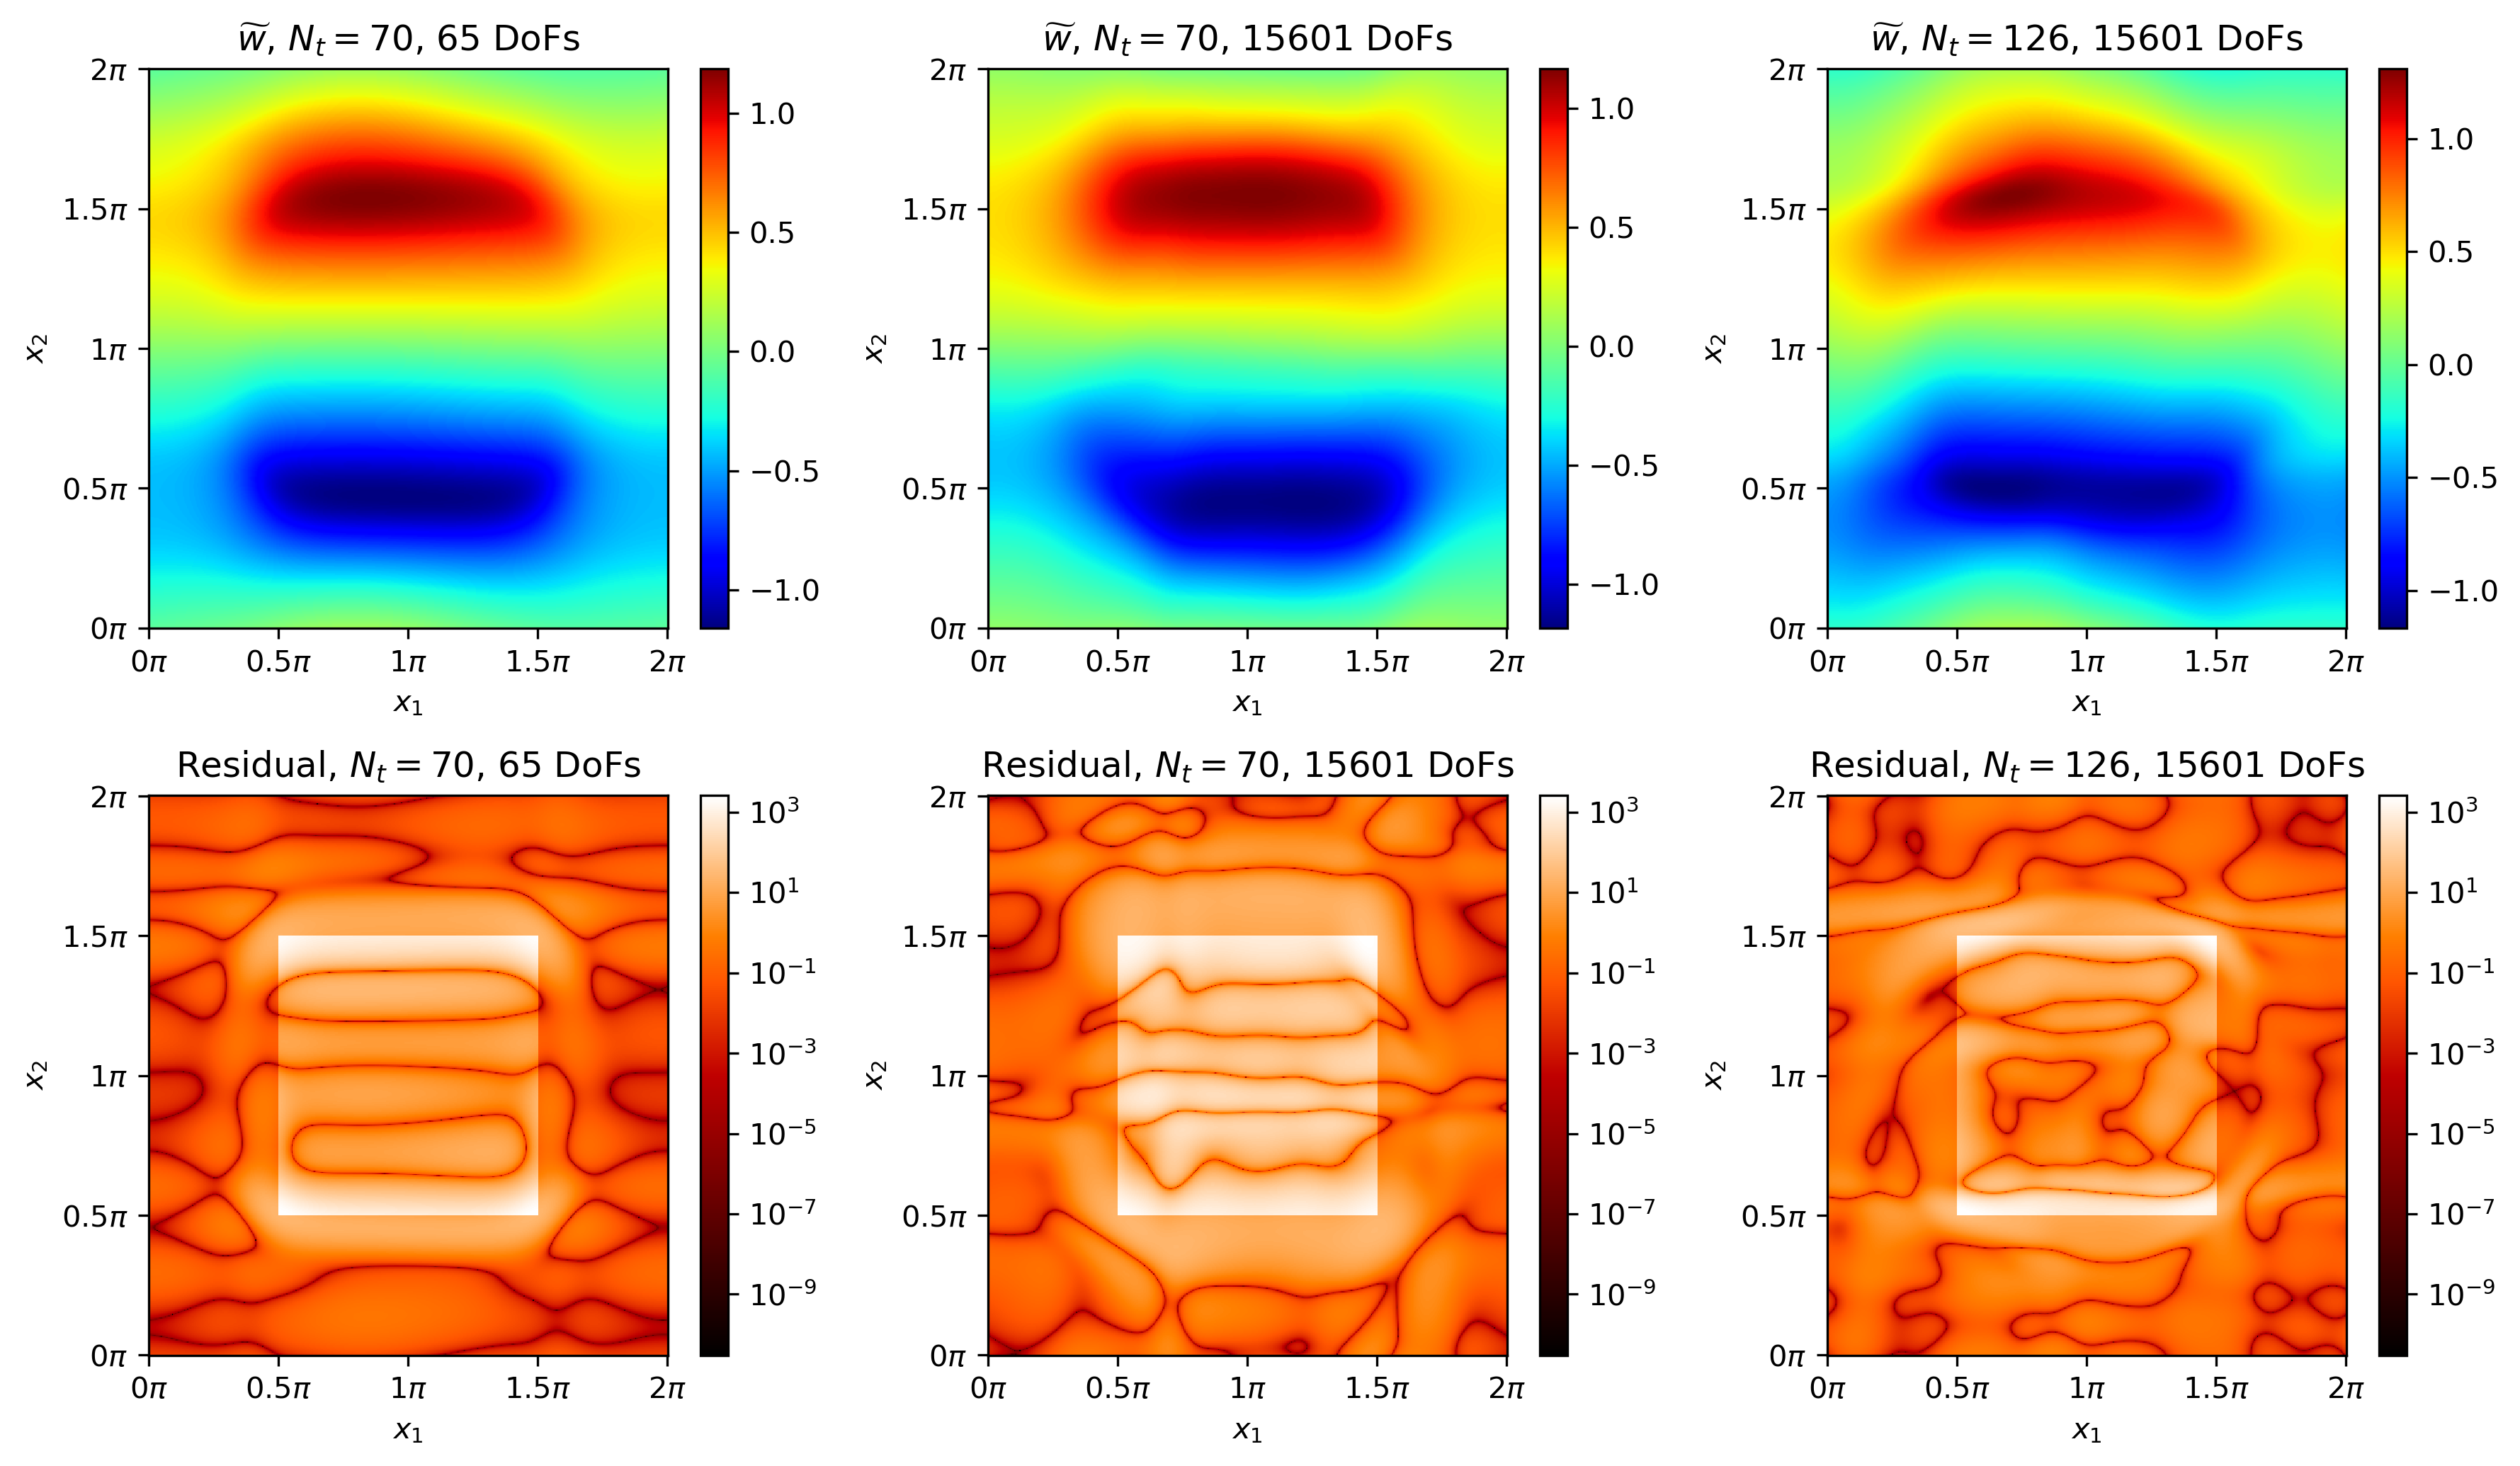

In [10]:
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,7), dpi=300)

for i in range(6):
    axs.flat[i].set_xlabel('$x_1$')
    axs.flat[i].set_ylabel('$x_2$')

pos1 = axs[0,0].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, W1_1, cmap='jet')
fig.colorbar(pos1, ax=axs[0,0])
pos2 = axs[0,1].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, W1_2, cmap='jet')
fig.colorbar(pos2, ax=axs[0,1])
pos3 = axs[0,2].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, W1_3, cmap='jet')
fig.colorbar(pos3, ax=axs[0,2])

axs[0,0].set_title('$\widetilde{w}$, $N_t=70$, 65 DoFs')
axs[0,1].set_title('$\widetilde{w}$, $N_t=70$, 15601 DoFs')
axs[0,2].set_title('$\widetilde{w}$, $N_t=126$, 15601 DoFs')

axs[1,0].set_title('Residual, $N_t=70$, 65 DoFs')
axs[1,1].set_title('Residual, $N_t=70$, 15601 DoFs')
axs[1,2].set_title('Residual, $N_t=126$, 15601 DoFs')

pos1 = axs[1,0].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_1_d**2, cmap='gist_heat', norm=LogNorm(vmin=(error_1_d**2).min(), vmax=(error_1_d**2).max()))
fig.colorbar(pos1, ax=axs[1,0])
pos2 = axs[1,1].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_2_d**2, cmap='gist_heat', norm=LogNorm(vmin=(error_2_d**2).min(), vmax=(error_2_d**2).max()))
fig.colorbar(pos1, ax=axs[1,1])
pos2 = axs[1,2].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_3_d**2, cmap='gist_heat', norm=LogNorm(vmin=(error_3_d**2).min(), vmax=(error_3_d**2).max()))
fig.colorbar(pos1, ax=axs[1,2])

for i in range(3):
    axs[0,i].xaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[0,i].xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[0,i].yaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[0,i].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[1,i].xaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[1,i].xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[1,i].yaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[1,i].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))

plt.tight_layout()

In [14]:
net_primal_65_50 = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_primal_{65}_{50}'}

net_primal_65_50 = load_network(net_primal_65_50, args['name']+'_39999', args)
net_primal_65_50 = net_primal_65_50.to(dev)

net_primal_15601_50 = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_primal_{15601}_{50}'}

net_primal_15601_50 = load_network(net_primal_15601_50, args['name']+'_39999', args)
net_primal_15601_50 = net_primal_15601_50.to(dev)

net_primal_15601_400 = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_primal_{15601}_{400}'}

net_primal_15601_400 = load_network(net_primal_15601_400, args['name']+'_39999', args)
net_primal_15601_400 = net_primal_15601_400.to(dev)

In [16]:
U1_1 = net_primal_65_50(grid_data).detach().cpu().reshape(N, N)
U1_2 = net_primal_15601_50(grid_data).detach().cpu().reshape(N, N)
U1_3 = net_primal_15601_400(grid_data).detach().cpu().reshape(N, N)

error_1_p, _, _ = PDE_loss(grid_data, net_primal_65_50, A, H1)
error_1_p = error_1_p.detach().cpu().reshape(N, N)

error_2_p, _, _ = PDE_loss(grid_data, net_primal_15601_50, A, H1)
error_2_p = error_2_p.detach().cpu().reshape(N, N)

error_3_p, _, _ = PDE_loss(grid_data, net_primal_15601_400, A, H1)
error_3_p = error_3_p.detach().cpu().reshape(N, N)

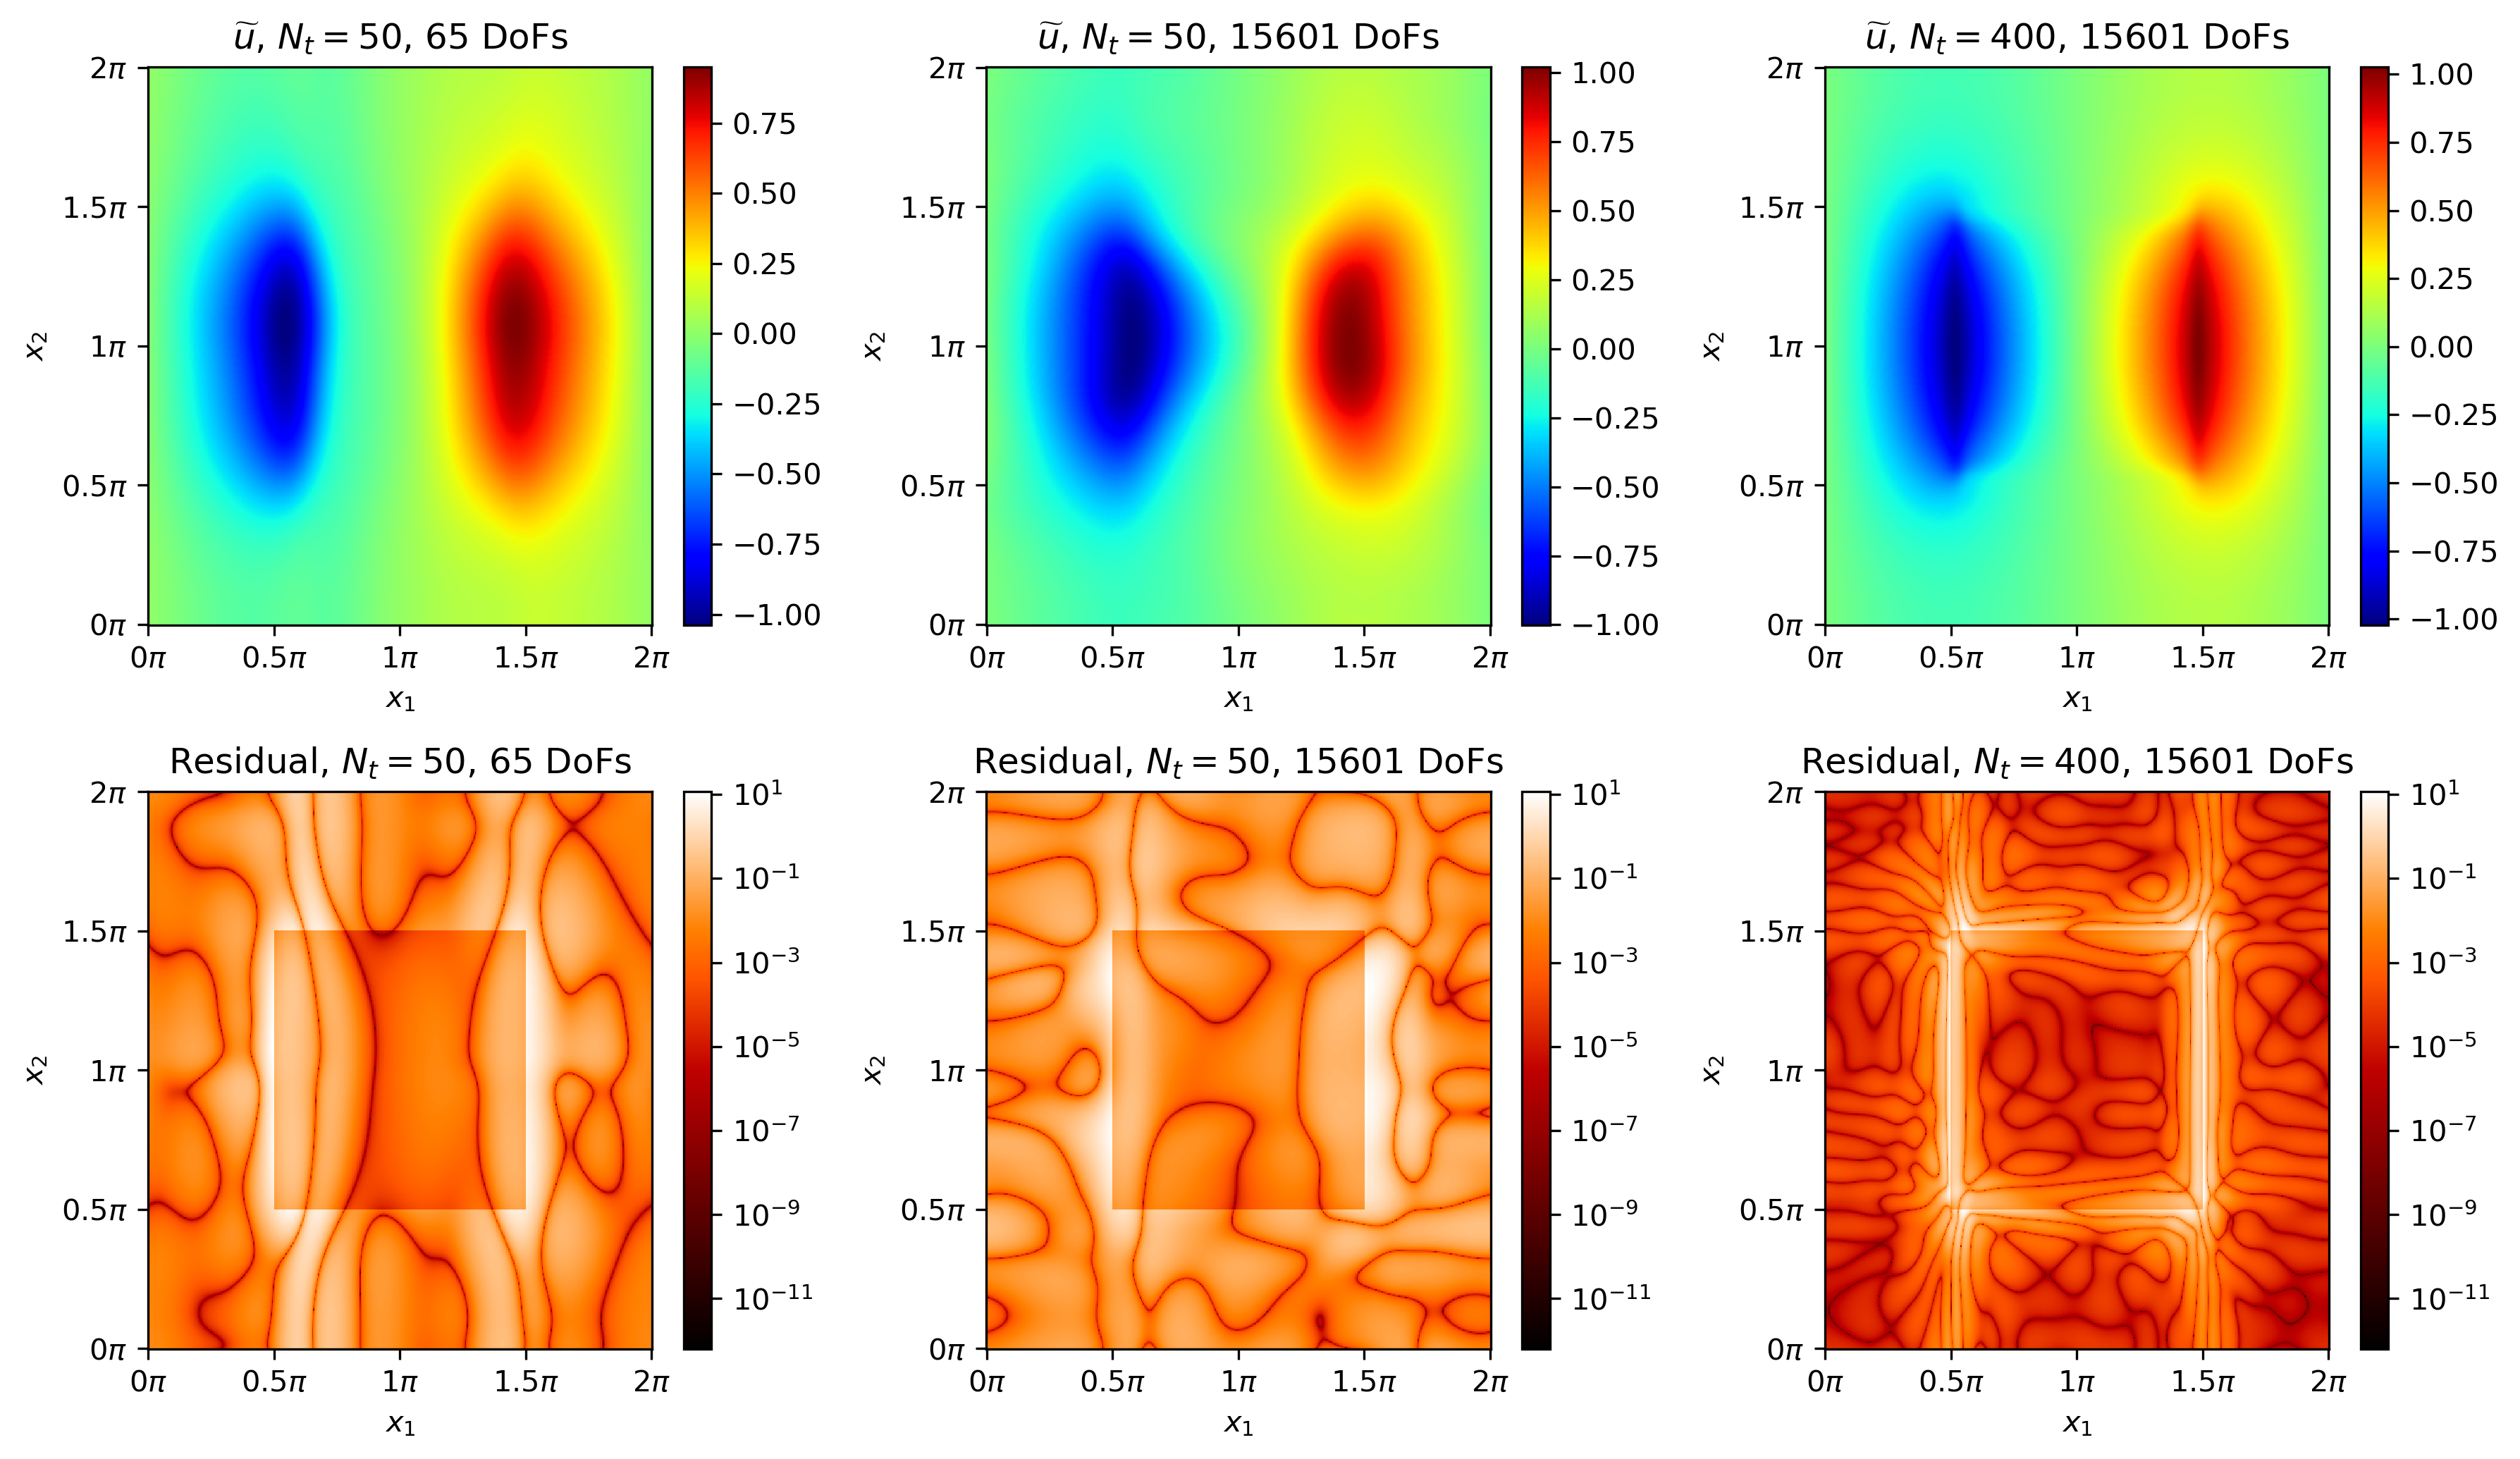

In [17]:
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,7), dpi=300)

for i in range(6):
    axs.flat[i].set_xlabel('$x_1$')
    axs.flat[i].set_ylabel('$x_2$')

pos1 = axs[0,0].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, U1_1, cmap='jet')
fig.colorbar(pos1, ax=axs[0,0])
pos2 = axs[0,1].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, U1_2, cmap='jet')
fig.colorbar(pos2, ax=axs[0,1])
pos3 = axs[0,2].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, U1_3, cmap='jet')
fig.colorbar(pos3, ax=axs[0,2])

axs[0,0].set_title('$\widetilde{u}$, $N_t=50$, 65 DoFs')
axs[0,1].set_title('$\widetilde{u}$, $N_t=50$, 15601 DoFs')
axs[0,2].set_title('$\widetilde{u}$, $N_t=400$, 15601 DoFs')

axs[1,0].set_title('Residual, $N_t=50$, 65 DoFs')
axs[1,1].set_title('Residual, $N_t=50$, 15601 DoFs')
axs[1,2].set_title('Residual, $N_t=400$, 15601 DoFs')

pos1 = axs[1,0].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_1_p**2, cmap='gist_heat', norm=LogNorm(vmin=(error_1_p**2).min(), vmax=(error_1_p**2).max()))
fig.colorbar(pos1, ax=axs[1,0])
pos2 = axs[1,1].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_2_p**2, cmap='gist_heat', norm=LogNorm(vmin=(error_2_p**2).min(), vmax=(error_2_p**2).max()))
fig.colorbar(pos1, ax=axs[1,1])
pos2 = axs[1,2].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_3_p**2, cmap='gist_heat', norm=LogNorm(vmin=(error_3_p**2).min(), vmax=(error_3_p**2).max()))
fig.colorbar(pos1, ax=axs[1,2])

for i in range(3):
    axs[0,i].xaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[0,i].xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[0,i].yaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[0,i].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[1,i].xaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[1,i].xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[1,i].yaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[1,i].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))

plt.tight_layout()

In [18]:
net_dual_65_50 = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_dual_{65}_{50}'}

net_dual_65_50 = load_network(net_dual_65_50, args['name']+'_39999', args)
net_dual_65_50 = net_dual_65_50.to(dev)

net_dual_15601_50 = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_dual_{15601}_{50}'}

net_dual_15601_50 = load_network(net_dual_15601_50, args['name']+'_39999', args)
net_dual_15601_50 = net_dual_15601_50.to(dev)

net_dual_15601_400 = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_dual_{15601}_{400}'}

net_dual_15601_400 = load_network(net_dual_15601_400, args['name']+'_39999', args)
net_dual_15601_400 = net_dual_15601_400.to(dev)

In [19]:
W1_1 = net_dual_65_50(grid_data).detach().cpu().reshape(N, N)
W1_2 = net_dual_15601_50(grid_data).detach().cpu().reshape(N, N)
W1_3 = net_dual_15601_400(grid_data).detach().cpu().reshape(N, N)

error_1_d, _, _ = PDE_loss_dual(grid_data, net_dual_65_50, A_inv, H1)
error_1_d = error_1_d.detach().cpu().reshape(N, N)

error_2_d, _, _ = PDE_loss_dual(grid_data, net_dual_15601_50, A_inv, H1)
error_2_d = error_2_d.detach().cpu().reshape(N, N)

error_3_d, _, _ = PDE_loss_dual(grid_data, net_dual_15601_400, A_inv, H1)
error_3_d = error_3_d.detach().cpu().reshape(N, N)

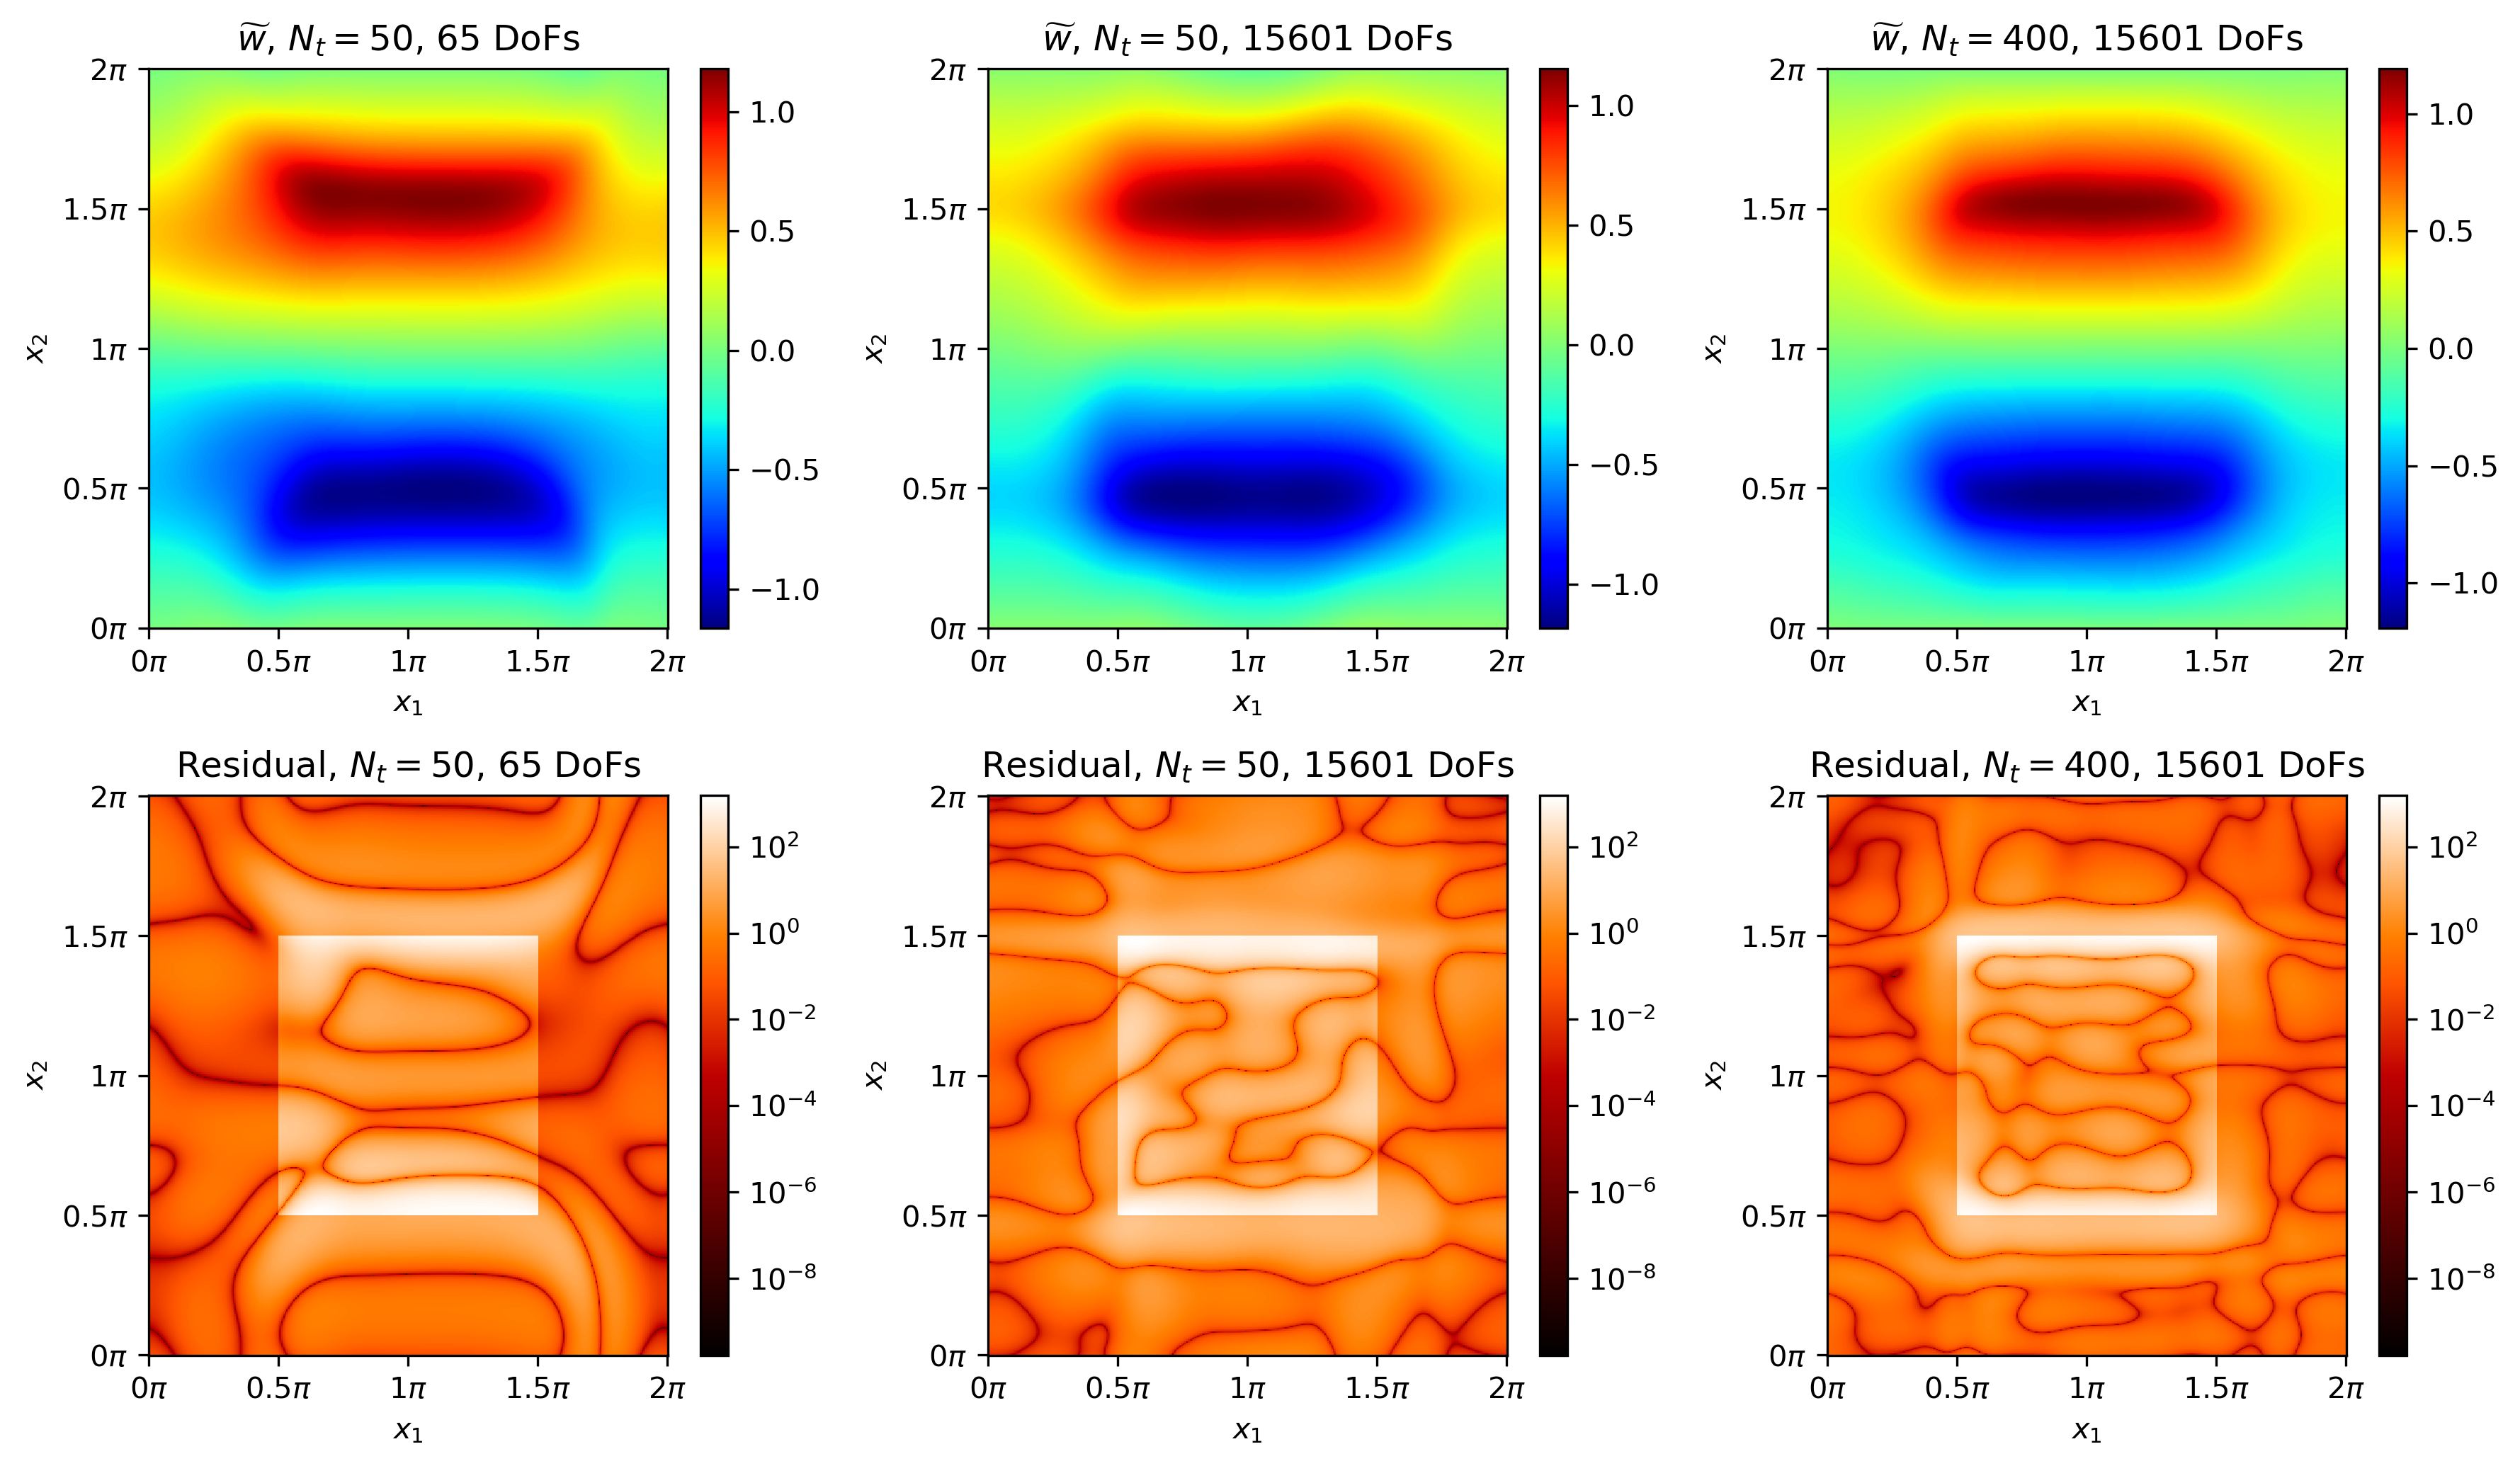

In [20]:
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,7), dpi=300)

for i in range(6):
    axs.flat[i].set_xlabel('$x_1$')
    axs.flat[i].set_ylabel('$x_2$')

pos1 = axs[0,0].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, W1_1, cmap='jet')
fig.colorbar(pos1, ax=axs[0,0])
pos2 = axs[0,1].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, W1_2, cmap='jet')
fig.colorbar(pos2, ax=axs[0,1])
pos3 = axs[0,2].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, W1_3, cmap='jet')
fig.colorbar(pos3, ax=axs[0,2])

axs[0,0].set_title('$\widetilde{w}$, $N_t=50$, 65 DoFs')
axs[0,1].set_title('$\widetilde{w}$, $N_t=50$, 15601 DoFs')
axs[0,2].set_title('$\widetilde{w}$, $N_t=400$, 15601 DoFs')

axs[1,0].set_title('Residual, $N_t=50$, 65 DoFs')
axs[1,1].set_title('Residual, $N_t=50$, 15601 DoFs')
axs[1,2].set_title('Residual, $N_t=400$, 15601 DoFs')

pos1 = axs[1,0].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_1_d**2, cmap='gist_heat', norm=LogNorm(vmin=(error_1_d**2).min(), vmax=(error_1_d**2).max()))
fig.colorbar(pos1, ax=axs[1,0])
pos2 = axs[1,1].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_2_d**2, cmap='gist_heat', norm=LogNorm(vmin=(error_2_d**2).min(), vmax=(error_2_d**2).max()))
fig.colorbar(pos1, ax=axs[1,1])
pos2 = axs[1,2].pcolormesh(XY[0]/np.pi, XY[1]/np.pi, error_3_d**2, cmap='gist_heat', norm=LogNorm(vmin=(error_3_d**2).min(), vmax=(error_3_d**2).max()))
fig.colorbar(pos1, ax=axs[1,2])

for i in range(3):
    axs[0,i].xaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[0,i].xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[0,i].yaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[0,i].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[1,i].xaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[1,i].xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
    axs[1,i].yaxis.set_major_formatter(tck.FormatStrFormatter('%g$\pi$'))
    axs[1,i].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))

plt.tight_layout()